### Model prediction analysis with test images

In [1]:
import matplotlib.pyplot as plt
import cv2
import os
import glob
from ultralytics import YOLO
import numpy as np
from typing import List, Tuple

Auxiliary functions are created to transform the coordinates of the labels generated by YOLO, plot the boxes and show in the image the labeled boxes and those predicted by the model.

In [2]:
def transform_yolo_labels(label_path: str, 
                     img_shape: Tuple[int, int, int]
                     ) -> List[List[int]]:
    """
    Loads ground truth (YOLO) labels from a file and converts them
    to absolute pixel coordinates based on the image size.

    Args:
        label_path (str): The path to the file containing the labels in YOLO format.
        img_shape (Tuple[int, int, int]): Image dimensions in (height, width, channels) format.

    Returns:
        List[List[int]]: A list of bounding boxes in [x_min, y_min, x_max, y_max] format.
    """
    h, w, _ = img_shape
    bboxes = []
    if os.path.exists(label_path):
        with open(label_path, 'r') as file:
            lines = file.readlines()
            for line in lines:
                # Each line is: class x_center y_center width height (normalized values ​​between 0 and 1)
                values = line.strip().split()
                x_center, y_center, width, height = map(float, values[1:])
                # Convert to [x_min, y_min, x_max, y_max] format in pixels
                x_min = int((x_center - width / 2) * w)
                y_min = int((y_center - height / 2) * h)
                x_max = int((x_center + width / 2) * w)
                y_max = int((y_center + height / 2) * h)
                bboxes.append([x_min, y_min, x_max, y_max])
    return bboxes


def draw_boxes(image: np.ndarray, 
               bboxes: List[List[int]], 
               color: Tuple[int, int, int], 
               label: str = "") -> None:
    """
    Draws bounding boxes on the image.

    Args:
        image (np.ndarray): The image on which the bounding boxes will be drawn.
        bboxes (List[List[int]]): List of bounding boxes in format [x_min, y_min, x_max, y_max].
        color (Tuple[int, int, int]): Color of the bounding boxes in format (B, G, R).
        label (str, optional): Label text to be drawn over each bounding box. Defaults to "".
    """
    for bbox in bboxes:
        x_min, y_min, x_max, y_max = bbox
        cv2.rectangle(image, (x_min, y_min), (x_max, y_max), color, 2)
        if label:
            cv2.putText(image, label, (x_min, y_min - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, color, 2)


def plot_predictions_with_labels(image_files: List[str], 
                                 results: List, 
                                 labels_path: str) -> None:
    """
    Displays images with model predictions and ground truth labels.

    Args:
        image_files (List[str]): List of paths to images.
        results (List): Model results containing bounding box predictions.
        labels_path (str): Path to ground truth labels.
    """
    plt.figure(figsize=(15, 10))
    
    for i, image_file in enumerate(image_files[:6]):
        img = cv2.imread(image_file)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # Cargar las etiquetas
        label_file = os.path.join(labels_path, os.path.basename(image_file).replace('.jpg', '.txt'))
        gt_bboxes = transform_yolo_labels(label_file, img_rgb.shape)

        # Obtener las predicciones del modelo
        result = results[i]
        pred_bboxes = result.boxes.xyxy.cpu().numpy().astype(int) 

        img_with_labels = img_rgb.copy()
        draw_boxes(img_with_labels, gt_bboxes, color=(0, 255, 0), label="Real") 
        draw_boxes(img_with_labels, pred_bboxes, color=(255, 0, 0), label="Prediction")

        plt.subplot(2, 3, i+1)
        plt.imshow(img_with_labels)
        plt.axis('off') 
        plt.title(f'Real vs. Prediction {i+1}')

    plt.tight_layout()
    plt.show()

In [3]:
# Load pre-trained YOLO model
model = YOLO('../runs/detect/qr_code_detection2/weights/best.pt')

In [4]:
# Path of test images and their labels
test_images_path = r'D:\qr_code_detection\models\qr_detection_dataset\test\images'
test_labels_path = r'D:\qr_code_detection\models\qr_detection_dataset\test\labels'
results = model.predict(source=test_images_path)


image 1/155 D:\qr_code_detection\models\qr_detection_dataset\test\images\0050027974_jpg.rf.269ad5f89a28942eb9ccf09507a77b22.jpg: 640x640 1 qr-code, 161.5ms
image 2/155 D:\qr_code_detection\models\qr_detection_dataset\test\images\0465484369_jpg.rf.5a008a07ddeab607b4ee760df70c279c.jpg: 640x640 1 qr-code, 117.2ms
image 3/155 D:\qr_code_detection\models\qr_detection_dataset\test\images\0575557590_jpg.rf.c298437c6e0fac5647c6335f71111142.jpg: 640x640 1 qr-code, 91.1ms
image 4/155 D:\qr_code_detection\models\qr_detection_dataset\test\images\0858847120_jpg.rf.36d3c000258e62b9b28a739e4fd118d3.jpg: 640x640 1 qr-code, 91.6ms
image 5/155 D:\qr_code_detection\models\qr_detection_dataset\test\images\1173_U7cZv88QC_jpg.rf.89d791a0e4ca605b3cc55d765504abe5.jpg: 640x640 1 qr-code, 89.2ms
image 6/155 D:\qr_code_detection\models\qr_detection_dataset\test\images\1317_U7u33GNuC_jpg.rf.baf7f723402c0ad6913c6fbb875f912d.jpg: 640x640 1 qr-code, 104.6ms
image 7/155 D:\qr_code_detection\models\qr_detection_datas

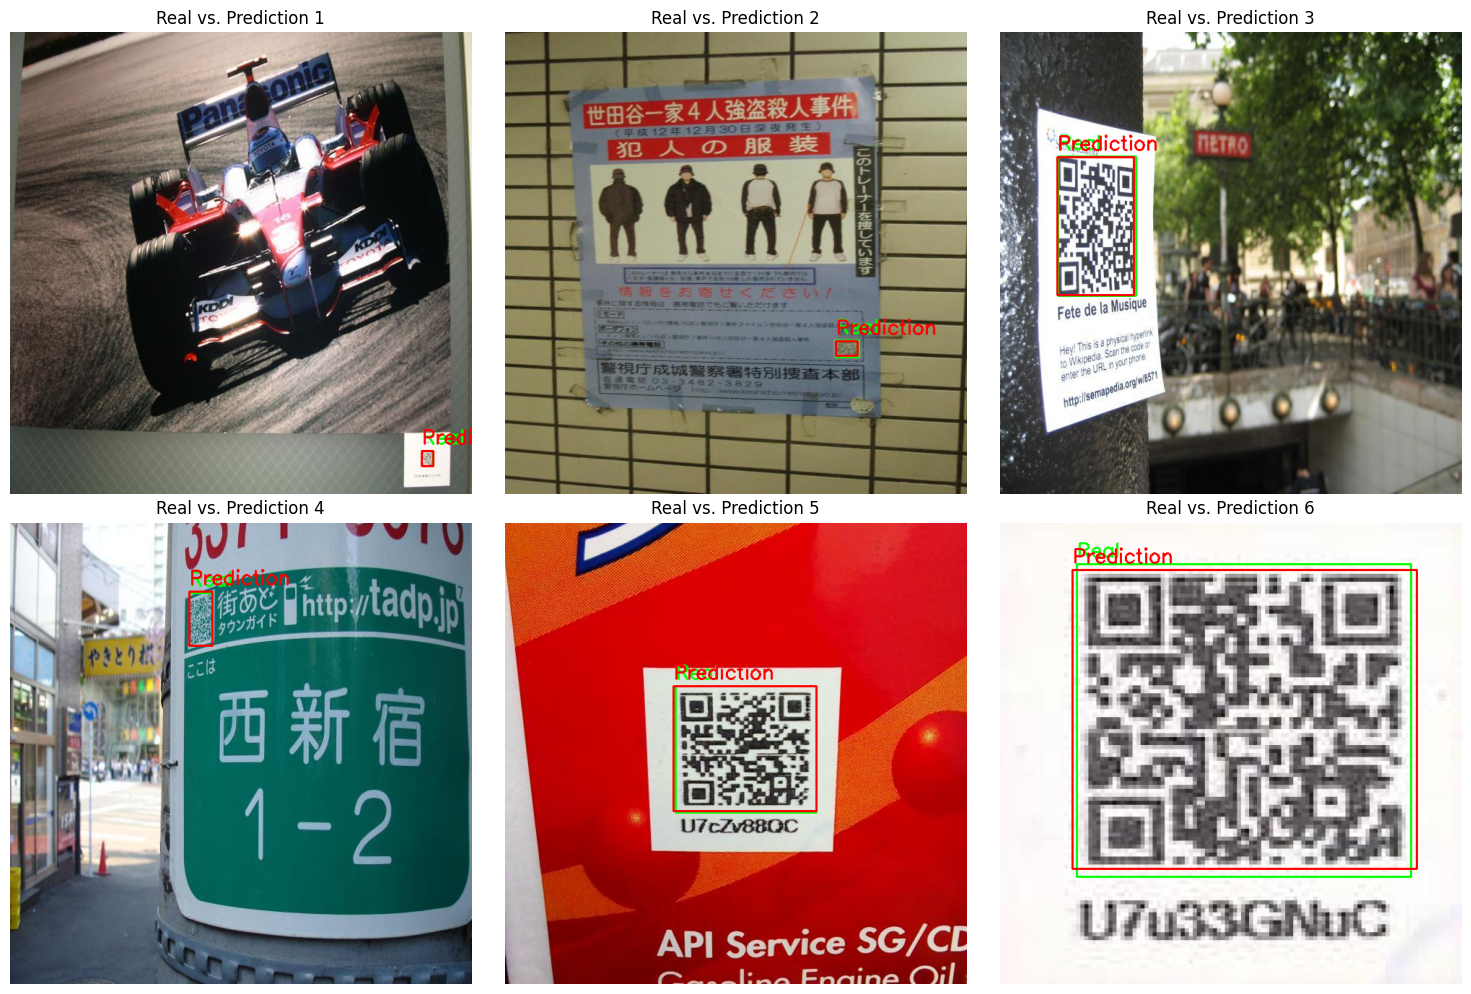

In [5]:
image_files = glob.glob(os.path.join(test_images_path, '*.jpg'))

# Display images with predictions and original labels
plot_predictions_with_labels(image_files, results, test_labels_path)

In [8]:
# Evaluate the model on the validation set using YOLO val
results = model.val(data=r'D:\qr_code_detection\models\qr_detection_dataset\data.yaml', split='val')

# Display metrics calculated on the val set
metrics = results.results_dict
print(metrics)

Ultralytics YOLOv8.2.90  Python-3.11.9 torch-2.4.1+cpu CPU (Intel Core(TM) i7-8565U 1.80GHz)


val: Scanning D:\qr_code_detection\models\qr_detection_dataset\valid\labels.cache... 309 images, 0 backgrounds, 0 corrupt: 100%|██████████| 309/309 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:36<00:00,  1.81s/it]


                   all        309        508      0.972      0.965      0.982      0.833
Speed: 1.4ms preprocess, 99.7ms inference, 0.0ms loss, 0.7ms postprocess per image
Results saved to runs\detect\val3
{'metrics/precision(B)': 0.9715657932236489, 'metrics/recall(B)': 0.9645669291338582, 'metrics/mAP50(B)': 0.9819646521567891, 'metrics/mAP50-95(B)': 0.8329116586046437, 'fitness': 0.8478169579598582}


In [11]:
# Evaluate the model on the test set using YOLO val
results = model.val(data=r'D:\qr_code_detection\model\qr_detection_dataset\data.yaml', split='test')

# Display metrics calculated on the test set
metrics = results.results_dict
print(metrics)

Ultralytics YOLOv8.2.90  Python-3.11.9 torch-2.4.1+cpu CPU (Intel Core(TM) i7-8565U 1.80GHz)


val: Scanning D:\qr_code_detection\model\qr_detection_dataset\test\labels.cache... 155 images, 0 backgrounds, 0 corrupt: 100%|██████████| 155/155 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:21<00:00,  2.11s/it]


                   all        155        303      0.986      0.936      0.977      0.799
Speed: 1.6ms preprocess, 117.6ms inference, 0.0ms loss, 0.7ms postprocess per image
Results saved to runs\detect\val
{'metrics/precision(B)': 0.9860880593738052, 'metrics/recall(B)': 0.9357216465356766, 'metrics/mAP50(B)': 0.9774040314092843, 'metrics/mAP50-95(B)': 0.7993005227193153, 'fitness': 0.8171108735883122}


### Interpretation of metrics on the test set

- High precision (0.986): The model is very good at making accurate predictions, with very few false positives.
- Recall (0.936): The model correctly detects most objects in the test set
- High mAP@50 (0.977): The model has an average accuracy of 97.7% on the test set when the prediction is required to have at least a 50% overlap with the ground truth label.
- Fair mAP@50-95 (0.799): Although the model is still strong, its performance decreases when more accurate overlap of the boxes is required (i.e. a higher level of accuracy in the predictions).
- Fitness (0.817): The model has a solid overall performance, being effective in terms of precision and recall.